In [1]:
import random
import os
from PIL import Image, ImageColor
from multiprocessing import Process, Queue

import cv2
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import augly.image as imaugs

from build_label import build_label
from models.unet import semantic_segmentation, u_net
from constant import CHANNEL_NUM

12


C:\Users\Minjoo Lee\.conda\envs\oemer\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
def preprocess_image(img_path):
    image = Image.open(img_path).convert("1")
    params = {}

    if image.mode == "1":
        # The input image contains only one channel.
        arr = np.array(image)
        out = np.zeros(arr.shape + (3,), dtype=np.uint8)
        bg_is_white = np.count_nonzero(arr) > (arr.size * 0.7)
        bg_idx = np.where(arr==bg_is_white)

        # Change background color
        hue = random.randint(19, 60)
        sat = random.randint(0, 15)
        val = random.randint(70, 100)
        color = ImageColor.getrgb(f"hsv({hue}, {sat}%, {val}%)")
        out[bg_idx[0], bg_idx[1]] = color
        image = Image.fromarray(out)
        params['bg_color'] = {'hue': hue, 'saturation': sat, 'value': val}

    # Color jitter
    bright = (7 + random.randint(0, 6)) / 10  # 0.7~1.3
    saturation = (5 + random.randint(0, 7)) / 10  # 0.5~1.2
    contrast = (5 + random.randint(0, 10)) / 10  # 0.5~1.5
    aug_image = imaugs.color_jitter(
        image, brightness_factor=bright, saturation_factor=saturation, contrast_factor=contrast)
    params['color_jitter'] = {'brightness': bright, 'saturation': saturation, 'contrast': contrast}

    # Blur
    rad = random.choice(np.arange(0.0001, 2.1, 0.5))
    aug_image = imaugs.blur(aug_image, radius=rad)
    params['blur_radius'] = rad

    # Pixel shuffle, kind of adding noise
    factor = random.choice(np.arange(0.0001, 0.26, 0.05))
    aug_image = imaugs.shuffle_pixels(aug_image, factor=factor)
    params['pixel_shuffle_factor'] = factor

    # Image quality
    qa = random.randint(0, 100)
    aug_image = imaugs.encoding_quality(aug_image, quality=qa)
    params['image_quality'] = qa

    # Opacity
    # level = random.randint(6, 10) / 10
    # aug_image = imaugs.opacity(aug_image, level=level)
    # params['opacity'] = level

    # Pixelize (pretty similar to blur?)
    rat = random.randint(3, 10) / 10
    aug_image = imaugs.pixelization(aug_image, ratio=rat)
    params['pixelize_ratio'] = rat

    # Add noise
    # var = random.randint(0, 5) / 100
    # aug_image = imaugs.random_noise(aug_image, var=var)
    # params['noise_variance'] = var

    return aug_image, params

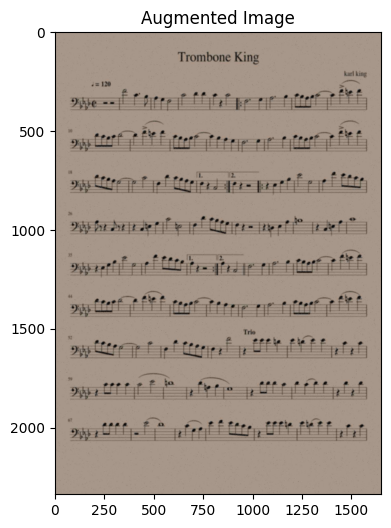

Augmentation Parameters: {'bg_color': {'hue': 26, 'saturation': 15, 'value': 80}, 'color_jitter': {'brightness': 0.8, 'saturation': 0.9, 'contrast': 1.4}, 'blur_radius': 2.0001, 'pixel_shuffle_factor': 0.050100000000000006, 'image_quality': 35, 'pixelize_ratio': 0.5}


In [3]:
import matplotlib.pyplot as plt

# 테스트용 이미지 경로 설정
test_img_path = "C:/Users/Minjoo Lee/MelodyDots/oemer/ds2_dense/images/2-2C Trombone King 0001.jpg"

# 함수 적용
augmented_image, params = preprocess_image(test_img_path)

# 변환된 이미지 출력
plt.figure(figsize=(10, 6))
plt.imshow(augmented_image)
plt.title("Augmented Image")
plt.show()

# 적용된 파라미터 출력
print("Augmentation Parameters:", params)

In [6]:
def preprocess_image(img_path):
    image = Image.open(img_path).convert("1")
    params = {}

    if image.mode == "1":
        # ... (Change background color)

    # Apply color jitter
    bright = (7 + random.randint(0, 6)) / 10  # 0.7~1.3
    saturation = (5 + random.randint(0, 7)) / 10  # 0.5~1.2
    contrast = (5 + random.randint(0, 10)) / 10  # 0.5~1.5
    aug_image = imaugs.color_jitter(
        image, brightness_factor=bright, saturation_factor=saturation, contrast_factor=contrast)
    params['color_jitter'] = {'brightness': bright, 'saturation': saturation, 'contrast': contrast}

    # Save the image after color jitter
    aug_image_color_jitter = aug_image.copy()

    # Apply blur
    rad = random.choice(np.arange(0.0001, 2.1, 0.5))
    aug_image = imaugs.blur(aug_image, radius=rad)
    params['blur_radius'] = rad

    # Save the image after blur
    aug_image_blur = aug_image.copy()

    # ... (Apply other augmentation techniques similarly)

    return aug_image_color_jitter, aug_image_blur, params

IndentationError: expected an indented block (826908693.py, line 9)